# Summary
There are two parts to how a movement between point A and point B might vary. The first is variance in the actual movement path taken to get from point A to point B, and the second is the speed of the movement. Here, I'll analyze the movement path variance, `var_p`, across all __Hit__ trials that successfully have movement from the first threshold to the second threshold and back to the first threshold (this back threshold will effectively be a third threshold) from 1 day (and ignore variance in speed for now).

Then the movements will be scaled across % completion of their entire movement path. This percent completion movement will be saved again in `output_folder` as a movement_percent_scaled_trial#.npy file.

I will then plot the variance of this path, `var_p`, over the % movement completion between the first to second to third threshold. I also calculate the average movement path, `mean_p`, for __Hit__ trials that had movement from the first to second to third threshold for this 1 day. Finally, I will save `var_p` and `mean_p` to .npy files.

__This book analyzes 1 day session.__

# What should be in analysis2 folder:
- movement_percent_scaled.npy of the movement data scaled between 0 and 100%
- mean_p.npy of E[paths]
- var_p.npy of Var[paths]
- num_movements.npy an integer of the number of movements extracted

### imports and plot settings:

In [159]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

In [160]:
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.autolayout"] = True

### set folder_name and day, `trial_i_to_start` and `num_trials`

In [161]:
name = 'ANA2'
session = '20231101_d6'
trial_i_to_start = 0
num_trials = 88

In [162]:
analysis1_folder = "../Data_Copy/AnalysisData/"+name+"/analysis1_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/analysis2_"+name+"_"+session+"/"
!mkdir {output_folder}

### Plot the movement paths across % movement completed as the x-axis

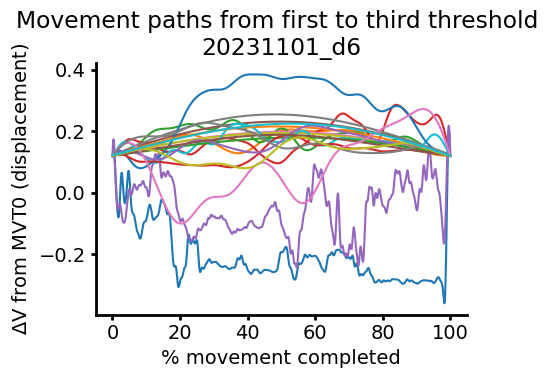

In [163]:
for movement_file in glob.glob(analysis1_folder+'movement_trial*.npy'):
    movement = np.load(movement_file)
    
    plt.plot(\
        (movement[0, :] - movement[0, 0]) *100 /(movement[0, -1] - movement[0, 0]),\
        movement[1, :]\
        )
plt.xlabel("% movement completed")
plt.ylabel("$\Delta$V from MVT0 (displacement)")
plt.title("Movement paths from first to third threshold \n"+session)
plt.show()

### Make functions scaled from 0-100% of movement path completion to analyze movement path variability
These scaled 0-100% movement path functions are made by linearly interpolating the original data at rates above sampling rate to make an approximate continuous function throughout the path. Right now, the `num_samples` = 10*10000 for a minimum sampling rate of 10kHz since __the movements all take less than 10s__.

Save all of them together in `movements_percent_scaled` and then into "movements_percent_scaled.npy" file.

`movements_percent_scaled`: rows are individual movements, columns are samples (so left to right is going forward in time)

In [164]:
num_samples = 10*10000
movements_percent_scaled = np.array([]).reshape((0, num_samples))

for movement_file in glob.glob(analysis1_folder+'movement_trial*.npy'):
    movement = np.load(movement_file)
    trial_i = int(re.search(r'(?<=trial).*?(?=.npy)',movement_file).group())
                  
    percent_completion_x = np.linspace(0, 100, movement[1,:].shape[0])

    movement_fcn = interpolate.interp1d(percent_completion_x, movement[1, :], kind='linear')
    new_x = percent_completion_x = np.linspace(0, 100, num_samples)
    new_y = movement_fcn(new_x)
    movements_percent_scaled = np.vstack([movements_percent_scaled, new_y[:]])

np.save(output_folder+"movement_percent_scaled", movements_percent_scaled)
print("movements_percent_scaled shape: ", movements_percent_scaled.shape)

movements_percent_scaled shape:  (20, 100000)


### calculate the movement path variance, `var_p`, across each movement in `movements_percent_scaled`
axis=0 runs downwards across rows

In [165]:
var_p=np.var(movements_percent_scaled, axis=0)

plot `var_p` across % movement completed

Text(0.5, 1.0, 'Variance of movement paths from first to second threshold \n20231101_d6')

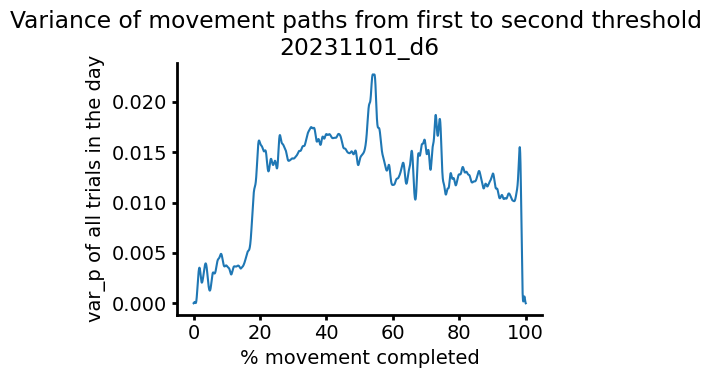

In [166]:
x_range = np.array(range(0,num_samples)) * 100 / num_samples
plt.plot(x_range, var_p)
plt.xlabel("% movement completed")
plt.ylabel("var_p of all trials in the day")
plt.title("Variance of movement paths from first to second threshold \n"+session)

### Also calculate the average movement path, `mean_ps`, across each `interpolated_movement_dataArduino`

In [167]:
mean_p=np.mean(movements_percent_scaled, axis=0)

plot `mean_p` across % movement completed

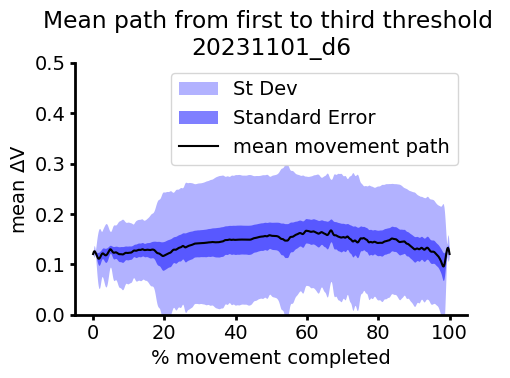

In [168]:
num_movements = len(glob.glob(analysis1_folder+'movement_trial*.npy'))
x_range = np.array(range(0,num_samples)) * 100 / num_samples
std = np.sqrt(var_p)
standard_error = np.sqrt(var_p/num_movements)

plt.fill_between(x_range, mean_p+std, mean_p-std, color='blue', alpha=0.3, label='St Dev', zorder=1, linewidth=0.0)
plt.fill_between(x_range, mean_p+standard_error, mean_p-standard_error, color='blue', alpha=0.5, label='Standard Error', zorder=2, linewidth=0.0)
plt.plot(x_range, mean_p, label="mean movement path", zorder=3, color='black')
plt.xlabel("% movement completed")
plt.ylabel("mean $\Delta$V")
plt.legend()
plt.title("Mean path from first to third threshold \n"+session)
plt.ylim([0, 0.5])
plt.savefig(output_folder + "path" + ".png")


### save `var_p` and `mean_p` to .npy files

In [169]:
np.save(output_folder+'var_p', var_p)
np.save(output_folder+'mean_p', mean_p)
np.save(output_folder+'num_movements', num_movements)